In [45]:

import numpy as np
import os
import random
from PIL import Image
import torch.nn as nn
from torchvision  import datasets,transforms
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt


**Preparing Datasets**

In [8]:
data_path = "/kaggle/input/potato-plant-diseases-data/"
# load datasets with ImageFolder
dataset = datasets.ImageFolder(data_path)


# Split the datasets into training ,validation ,and test sets
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset)-train_size-val_size

train_dataset , val_dataset,test_dataset = random_split(dataset,[train_size, val_size , test_size])

#calculate the number of samples in each dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(f"Number of Samples in training set:{train_size}")
print(f"Number of Samples in validation set:{val_size}")
print(f"Number of Samples in test set:{test_size}")

#Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()   
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()   
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()   
    ])
}


# Apply appropriate transforms to each split
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']


Number of Samples in training set:3443
Number of Samples in validation set:430
Number of Samples in test set:431


**Create DataLoaders**

In [9]:
train_loader=DataLoader(train_dataset,batch_size=30,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=30,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=30,shuffle=False)


Image batch dimensions: torch.Size([30, 3, 256, 256])
Image label dimensions: torch.Size([30])


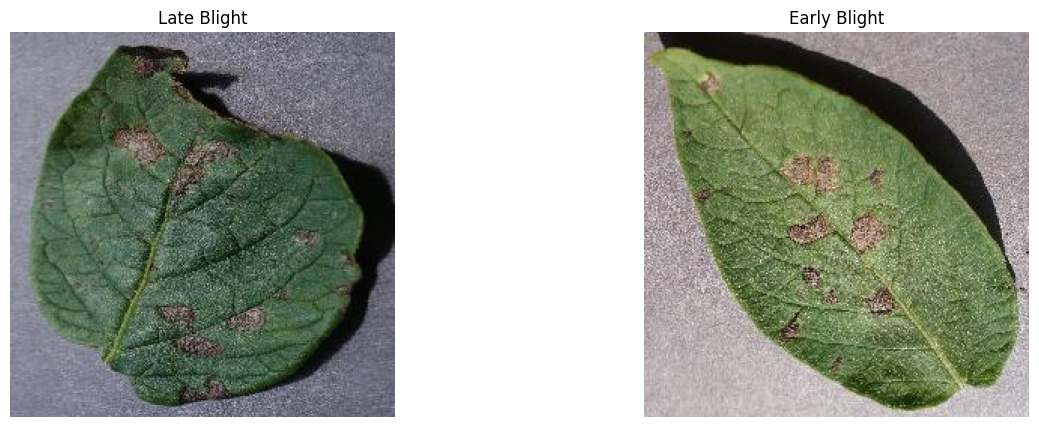

In [66]:

# Define a function to display images with labels
def show_images_labels(images, labels, label_names):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        # Convert image tensor to numpy array and transpose
        image = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(image)
        ax.set_title(label_names[labels[i].item()])
        ax.axis('off')
    plt.show()

# Assuming label_names is a list that maps label indices to plant conditions
label_names = ["Early Blight","Late Blight","Healthy"]

# Get a batch of training data
images, labels = next(iter(train_loader))

# Show the size and shape of images
print(f"Image batch dimensions: {images.size()}")
print(f"Image label dimensions: {labels.size()}")

# Visualize some images with labels
show_images_labels(images[:2], labels[:2], label_names)



**Build Model**

In [22]:
class CNNModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=2,padding=1),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(32,64,kernel_size=2,padding=1),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64,128,kernel_size=2,padding=1),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten()
        )
        self.classifier = nn.Linear(128*32*32,num_classes)
        
    def forward(self,x):
        x=self.feature_extractor(x)
        x=self.classifier(x)
        return x

**Training and Validation**

In [69]:
import torch.optim as optim
Model = CNNModel(num_classes=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(),lr=1e-5)
num_epochs = 10

for epoch in range(num_epochs):
    Model.train()
    running_loss = 0.0
    for images,labels in train_loader:
        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    

Epoch 1/10, Loss: 0.7253541174142257
Epoch 2/10, Loss: 0.7010104298591614
Epoch 3/10, Loss: 0.696574200236279
Epoch 4/10, Loss: 0.6982547500859136
Epoch 5/10, Loss: 0.6957036686980206
Epoch 6/10, Loss: 0.6980083740275839
Epoch 7/10, Loss: 0.6971495472866556
Epoch 8/10, Loss: 0.6972777408102284
Epoch 9/10, Loss: 0.6957286352696626
Epoch 10/10, Loss: 0.6973651196645654


**Validation of Model**

In [36]:
import torch
# Validation loop
Model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = Model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

Validation Loss: 0.7787805199623108, Accuracy: 17.674418604651162%


**Evaluation of Model**

Test Accuracy: 17.865429234338748%


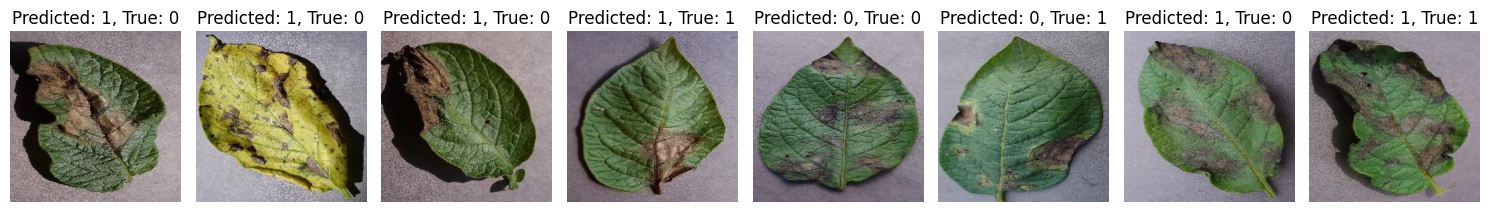

In [68]:
import matplotlib.pyplot as plt
Model.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []
images_list = []

# Function to display images with predictions
def imshow(img, ax, title=None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        ax.set_title(title)
    ax.axis('off')

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect images, predicted and true labels for visualization
        images_list.append(images)
        predicted_labels.extend(predicted)
        true_labels.extend(labels)

print(f"Test Accuracy: {100 * correct / total}%")

# Plot a few test images with their predictions
num_images_to_show = 8
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))
for i in range(num_images_to_show):
    img = images_list[0][i]  # Taking images from the first batch
    ax = axes[i]
    imshow(img, ax, title=f'Predicted: {predicted_labels[i]}, True: {true_labels[i]}')

plt.tight_layout()
plt.show()